In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


Check the current GPU usage. Please try to be nice!

In [17]:
!nvidia-smi

Fri Jul 24 20:39:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 40%   57C    P2    94W / 250W |   7644MiB / 12066MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   79C    P0   104W / 250W |   6627MiB / 16280MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 5

# Name is the output file name


##  200719  mds
folder = '24July2020_Trks_to_KDE'
name = '24July2020_Trks_to_KDE'

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 32

# How fast to learn
learning_rate = 3e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_July2020 import collect_t2kde_data

# From model/loss.py
##from loss import Loss
from model.kde_loss_A import Loss

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below


from model.models_kde import TracksToKDE_A as Model

from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
##device = select_gpu(2)
device = "cpu"

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:

## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch

train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                           device=device,
                           slice = slice(None,18000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5 in 6.203 s
Constructing 18000 event dataset took 0.08182 s
x_t.shape =  torch.Size([18000, 3600])
x_t.shape[0] =  18000
x_t.shape[1] =  3600
x_t.shape =  torch.Size([18000, 3600])
Loading data...
Loaded /share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5 in 5.98 s
Constructing 2000 event dataset took 0.0101 s
x_t.shape =  torch.Size([2000, 3600])
x_t.shape[0] =  2000
x_t.shape[1] =  3600
x_t.shape =  torch.Size([2000, 3600])


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
loss = Loss(epsilon=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=6, out_features=8, bias=True)
ct, child =  1    Linear(in_features=8, out_features=12, bias=True)
ct, child =  2    Linear(in_features=12, out_features=4000, bias=True)


In [11]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

Let's move the model's weight matricies to the GPU:

In [12]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
pretrained_dict = torch.load('ML/Aug17_FourFeature_CNN6LayerPlus_TargetsAA_Loss_A_1p0_final.pyt')
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


output =  ML/24July2020_Trks_to_KDE
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
 
   for pretrained_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4of6.weight
index, k =   7    conv4of6.bias
index, k =   8    conv5of6.weight
index, k =   9    conv5of6.bias
index, k =   10    finalFilter.weight
index, k =   11    finalFilter.bias
index, k =   12    ppConv1.weight
index, k =   13    ppConv1.bias
index, k =   14    ppConv2.weight
index, k =   15    ppConv2.bias
index, k =   16    ppConv3.weight
index, k =   17    ppConv3.bias
index, k =   18    ppFc1.weight
index, k =   19    ppFc1.bias
index, k =   20    ppFinalFilter.weight
index, k =   21    ppFinalFilter.bias
model_dict ins

_IncompatibleKeys(missing_keys=['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias', 'layer3.weight', 'layer3.bias'], unexpected_keys=[])

In [13]:
##model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


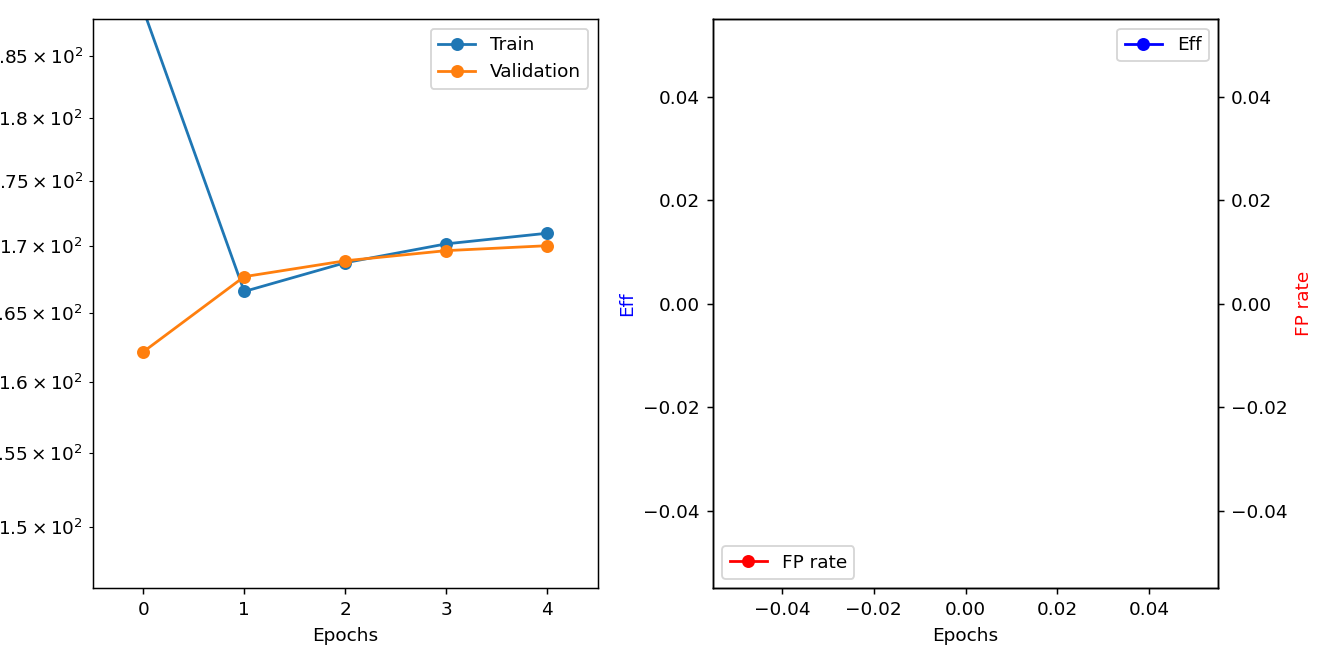

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    print("results appended")
    xs = results.index
    print("xs = ",xs)
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 563, val = 63


Number of batches: train = 563, val = 63
epoch_iterator created
another epoch in epoch_iterator loop
about to execute total_train_loss = train( ...
enter train(...  


created loader = progress ...  
returned from executing total_train_loss = train( ...
cost_epoch =  188.89376535635859
about to execute total_val_loss = validate( ... 
total_val_loss =  10217.049583435059
val_epoch =  162.1753902132549
time_epoch =  177.20299673080444
Epoch 0: train=188.894, val=162.175, took 177.2 s
results appended
xs =  RangeIndex(start=0, stop=1, step=1)
another epoch in epoch_iterator loop
about to execute total_train_loss = train( ...
enter train(...  


created loader = progress ...  
returned from executing total_train_loss = train( ...
cost_epoch =  166.59702984012043
about to execute total_val_loss = validate( ... 
total_val_loss =  10565.198364257812
val_epoch =  167.7015613374256
time_epoch =  175.51917028427124
Epoch 1: train=166.597, val=167.702, took 175.52 s
results appended
xs =  RangeIndex(start=0, stop=2, step=1)
another epoch in epoch_iterator loop
about to execute total_train_loss = train( ...
enter train(...  


created loader = progress ...  
returned from executing total_train_loss = train( ...
cost_epoch =  168.7455405308129
about to execute total_val_loss = validate( ... 
total_val_loss =  10640.183990478516
val_epoch =  168.89180937267486
time_epoch =  176.6112630367279
Epoch 2: train=168.746, val=168.892, took 176.61 s
results appended
xs =  RangeIndex(start=0, stop=3, step=1)
another epoch in epoch_iterator loop
about to execute total_train_loss = train( ...
enter train(...  


created loader = progress ...  
returned from executing total_train_loss = train( ...
cost_epoch =  170.16999215215816
about to execute total_val_loss = validate( ... 
total_val_loss =  10688.376075744629
val_epoch =  169.6567631070576
time_epoch =  175.9534478187561
Epoch 3: train=170.17, val=169.657, took 175.95 s
results appended
xs =  RangeIndex(start=0, stop=4, step=1)
another epoch in epoch_iterator loop
about to execute total_train_loss = train( ...
enter train(...  


created loader = progress ...  
returned from executing total_train_loss = train( ...
cost_epoch =  170.97770602834373
about to execute total_val_loss = validate( ... 
total_val_loss =  10711.862419128418
val_epoch =  170.02956220838757
time_epoch =  265.5552752017975
Epoch 4: train=170.978, val=170.03, took 265.56 s
results appended
xs =  RangeIndex(start=0, stop=5, step=1)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [ ]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [ ]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

In [ ]:
quit()